# Self-driving Car Project 5: Vehicle Detection and Tracking
The goals / steps of this project are the following:

* Training a classifier to detect vehicle images using spatial feature, color histogram features, and HOG features.

* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.

* Run the pipeline on a video stream of the previous project and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.




In [63]:
# Import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
%matplotlib inline
import time
import math
import pickle
# Libaries for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML
outdir= "modelsol"
outdir1="video2image"
pi = 3.14159
% matplotlib inline
data = pickle.load( open( "PROJECT4/camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]
kernel = 5
window = 60

### 1 Loading Images
Loading traniang and test data from their respective folders.

Training dataset 
1. cars: GTI_far, GTI_left, GTI_right, GTI_MiddleClose
2. non-cars: Extra

test dataset
1. cars: KITTI_extracted 
2. non-cars: GTI 

In [2]:
cars_train = []
notcars_train = []
images = glob.glob('vehicles/KITTI_extracted/*.png') # cars
for image in images:
    cars_train.append(image)
images = glob.glob('non-vehicles/Extras/*.png') # noncars
for image in images:
    notcars_train.append(image)

In [3]:
cars_test = []
notcars_test = []
images = glob.glob('vehicles/GTI_Far/*.png') # cars
for image in images:
    cars_test.append(image)    
images = glob.glob('vehicles/GTI_Left/*.png') # cars
for image in images:
    cars_test.append(image)
images = glob.glob('vehicles/GTI_MiddleClose/*.png') # cars
for image in images:
    cars_test.append(image)
images = glob.glob('vehicles/GTI_Right/*.png') # cars
for image in images:
    cars_test.append(image)
images = glob.glob('non-vehicles/GTI/*.png') # noncars
for image in images:
    notcars_test.append(image)

### 0.2 Data Summary
Get some basic information of the data set such as the number of images, and the images size

In [4]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Car images:     5966
Non-car images: 5068
Image size:     (64, 64, 3)
Data type:      float32


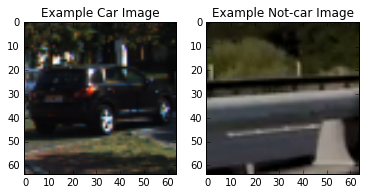

In [5]:
# Basic data summary
data_info = data_look(cars_train, notcars_train)
print('Car images:    ', data_info["n_cars"])
print('Non-car images:', data_info["n_notcars"])
print('Image size:    ', data_info["image_shape"])
print('Data type:     ', data_info["data_type"])


# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars_train))
notcar_ind = np.random.randint(0, len(notcars_train))
    
# Read in car / not-car images
car_image = mpimg.imread(cars_train[car_ind])
noncar_image = mpimg.imread(notcars_train[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Example Not-car Image')

## 2. Define Features
Define features for the vehicle classification. 
Three types of features are used: 

* Spatial feature
* Color histogram features
* HOG features.

### Convert Image Datatype
The images in the training data set are of the jpeg format, with float data values range from 0-1. The test images are of the png format, range from 0-255. To be consistent with the images type in the later process. I first convert the training image data type to int type with value from 0 to 255 

In [6]:
# convert data type to int range from 0 to 255
image_rgb = np.uint8(car_image*255)# convert to 255

### 1.2 Spatial Features
Spatial feature uses the raw pixel values of the images and flattens them into a vector. To reduce the size of the image, I performed spatial binning on an image by resizing the image to the lower resolution.

In [7]:
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return spatial_features 

Spatial features size: (192,)


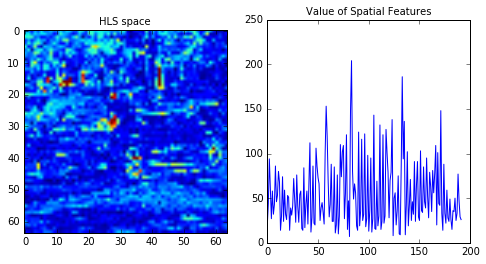

In [8]:
# set tuning parameters
spatial = 8 # size of the spacial bins

# convert it to HLS color space
image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)

# Extract spatial features, work on the saturation channel
spatial_s = bin_spatial(image_hls, size=(spatial, spatial))

print('Spatial features size:', spatial_s.shape)

# Visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image_hls[:,:,2])
ax1.set_title('HLS space', fontsize=10)
ax2.plot(spatial_s)
ax2.set_title('Value of Spatial Features', fontsize=10)


### 1.3 Color Histogram Features
Color Histogram feature is more robust to the different the appearance of the car.  The Color Histogram remove the structural relation and allow more flexibility to the variance of the image.
Binning is performed to the histogram of each channel. Both the RGB and HLS channels are used. 

In [9]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256),hist_vec=True):
    # Compute the histogram of the RGB channels separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    
    if hist_vec == False:
        # Return the individual channel histograms, bin_centers and feature vector    
        return hist1, hist2, hist3, bin_centers, hist_features
    else:
        # only return feature vector
        return hist_features

color hist features size: (36,)


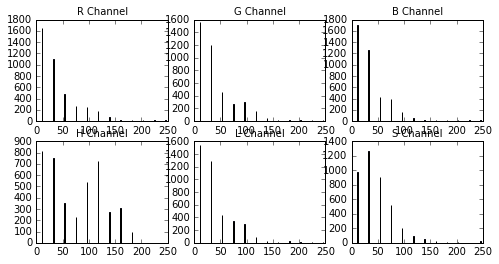

In [10]:
# set tunning parameter
histbin = 12 #number of bins

# GRB color space
rh, gh, bh, bincen, hist_rgb = color_hist(image_rgb, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)
# HLS color space
hh, lh, sh, bincen, hist_hls = color_hist(image_hls, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)

print('color hist features size:', hist_rgb.shape)

# Visualize histogram
f, ((ax1, ax2,ax3),(ax4, ax5,ax6) )= plt.subplots(2, 3, figsize=(8,4))
# R Channel
ax1.bar(bincen, rh[0])
ax1.set_title('R Channel', fontsize=10)
# G Channel
ax2.bar(bincen, gh[0])
ax2.set_title('G Channel', fontsize=10)
# B Channel
ax3.bar(bincen, bh[0])
ax3.set_title('B Channel', fontsize=10)

# H Channel
ax4.bar(bincen, hh[0])
ax4.set_title('H Channel', fontsize=10)
# L Channel
ax5.bar(bincen, lh[0])
ax5.set_title('L Channel', fontsize=10)
# S Channel
ax6.bar(bincen, sh[0])
ax6.set_title('S Channel', fontsize=10)

### 1.4 HOG Feature
Gradient features is also used to capture the signature for a shape. However use the gradient feature directly is sensitive.  Histogram of gradient orientation allows variation  between the shape. The HOG is on the grey scale image.

In [11]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Hog features shape: (4, 4, 2, 2, 8)
Flatterned Hog features size: (512,)


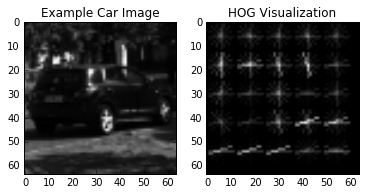

In [12]:
# work on grey scale image
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY) # convert to gray scale

# Define HOG parameters
orient = 8
pix_per_cell = 12
cell_per_block = 2

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features, hog_image = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features) 

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# test the funtion
print('Hog features shape:', hog_features.shape)
print('Flatterned Hog features size:', hog_1d.shape)

### 1.5 Extract Featuress
Combine all the extrected features

In [13]:
def extract_features(image_rgb):   
    # Spatial feature parameters
    spatial = 8 
    # color hist feature parameters
    hist_bins = 12 
    # HOG feature parameters
    orient = 8
    pix_per_cell = 12
    cell_per_block = 2
    
    # apply color conversion  
    image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)# convert it to HLS
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)# convert it to grayscale
        
    # Apply bin_spatial() to get spatial color features
    spatial_hls = bin_spatial(image_hls, size=(spatial, spatial)) # on HLS space 
    spatial_rgb = bin_spatial(image_rgb, size=(spatial, spatial)) # on Graysacle 
        
    # Apply color_hist() also with a color space option now
    hist_hls = color_hist(image_hls, nbins = hist_bins, 
                          bins_range = (0, 256), hist_vec=True) # on HLS space 
    hist_rgb = color_hist(image_rgb, nbins= hist_bins, 
                          bins_range = (0, 256), hist_vec=True) # on Graysacle     
        
    # Apply get_hog_features() with vis=False, feature_vec=True
    hog_grey = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        
    # Append the new feature vector to the features list
    features = np.concatenate((spatial_hls,spatial_rgb,
                               hist_hls,hist_rgb,
                               hog_grey))                                    
    return features

In [14]:
# extract features from the training image
def features_from_data(imgs):
    # Create a list to append feature vectors to
    features_all = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        image_rgb = np.uint8(image*255)# convert to 255

        features = extract_features(image_rgb) # extract features
        
        features_all.append(features)
    return features_all                  

In [15]:
# extract feature from the training set
car_features_train = features_from_data(cars_train) # car 
notcar_features_train = features_from_data(notcars_train) # non-car
# stacking car and non-car data together
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float32)   


# extract feature from the testing set
car_features_test = features_from_data(cars_test) # car
notcar_features_test = features_from_data(notcars_test) # non-car
# stacking car and non-car data together
X_test = np.vstack((car_features_test, notcar_features_test)).astype(np.float32)   

# print the dataset size
print("Training set:",X_train.shape)
print("Testing set :",X_test.shape)

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Training set: (11034, 968)
Testing set : (6726, 968)


### 1.6 Feature Normalization

In [16]:
# use standardscaler, which removing the mean and scaling to unit variance
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to the training set
scaled_X_train = X_scaler.transform(X_train)
# Apply the scaler to the testing set
scaled_X_test = X_scaler.transform(X_test)

In [17]:
# make the labels, cars get 1, non-car get 0
# training set
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
# testing set
y_test = np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))

In [18]:
# print data size
print('Training set:', scaled_X_train.shape)
print('Test set    :', scaled_X_test.shape)
print('Training set:', y_train.shape)
print('Test set    :', y_test.shape)

Training set: (11034, 968)
Test set    : (6726, 968)
Training set: (11034,)
Test set    : (6726,)


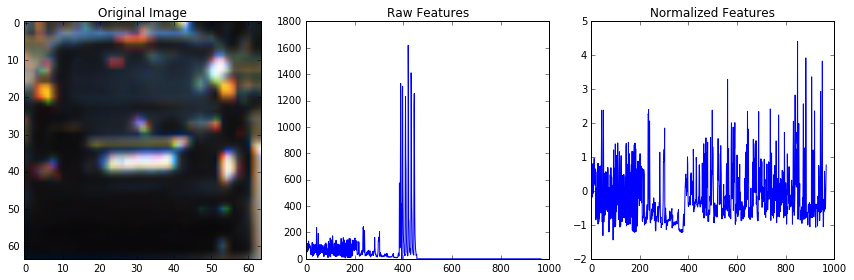

In [19]:
# plot feature normalization
car_ind = np.random.randint(0, len(cars_train))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars_train[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X_train[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X_train[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### 1.8 Make Training, Testing, and Validation set

In [20]:
# shuffle the training set
X_train, y_train = shuffle( scaled_X_train, y_train, random_state=42)

In [21]:
# split the test set into validation set (50%) and testing set (50%)
X_test, X_valid, y_test, y_valid = train_test_split(
    scaled_X_test, y_test, test_size=0.5, random_state=42)

In [22]:
print('Training set  :', X_train.shape)
print('Validation set:', X_valid.shape)
print('Testing set   :', X_test.shape)

Training set  : (11034, 968)
Validation set: (3363, 968)
Testing set   : (3363, 968)


## 2. Define Classifier
Train and fine-tune a random forests classifer for vehicle detection.

### Tuning Classifier Parameters
Use grid search to find tuning the parameters

In [23]:
# Tuning Classifier Parameters

# max_feature
x = [3,4,6] 
# max_depth 
y = [4,8,25]
# tree leaf
z = [2,4]

# grid search
for i in x:
    for j in y:
        for k in z:
            print ("ftr: {} ,dpt: {} ,lef: {}".format(i,j,k ))
            clf = RandomForestClassifier(n_estimators = 100,
                                         max_features = i,
                                         max_depth = j,
                                         min_samples_leaf = k,
                                         random_state = 42,) 
            # fit the classifier
            clf.fit(X_train, y_train)
            # predict
            pred = clf.predict_proba(X_valid)[:,1]
            # compute auroc score
            auroc = roc_auc_score(y_valid, pred)
            print('auroc = ', round(auroc, 4))

ftr: 3 ,dpt: 4 ,lef: 2
auroc =  0.9722
ftr: 3 ,dpt: 4 ,lef: 4
auroc =  0.9706
ftr: 3 ,dpt: 8 ,lef: 2
auroc =  0.9709
ftr: 3 ,dpt: 8 ,lef: 4
auroc =  0.969
ftr: 3 ,dpt: 25 ,lef: 2
auroc =  0.9655
ftr: 3 ,dpt: 25 ,lef: 4
auroc =  0.968
ftr: 4 ,dpt: 4 ,lef: 2
auroc =  0.9614
ftr: 4 ,dpt: 4 ,lef: 4
auroc =  0.9635
ftr: 4 ,dpt: 8 ,lef: 2
auroc =  0.9703
ftr: 4 ,dpt: 8 ,lef: 4
auroc =  0.9709
ftr: 4 ,dpt: 25 ,lef: 2
auroc =  0.9604
ftr: 4 ,dpt: 25 ,lef: 4
auroc =  0.9678
ftr: 6 ,dpt: 4 ,lef: 2
auroc =  0.967
ftr: 6 ,dpt: 4 ,lef: 4
auroc =  0.9667
ftr: 6 ,dpt: 8 ,lef: 2
auroc =  0.9603
ftr: 6 ,dpt: 8 ,lef: 4
auroc =  0.9642
ftr: 6 ,dpt: 25 ,lef: 2
auroc =  0.9557
ftr: 6 ,dpt: 25 ,lef: 4
auroc =  0.9634


### 2.2 Evaluate the Classifier

In [24]:
# the best parameters
clf = RandomForestClassifier(n_estimators=100, max_features = 2,
                             min_samples_leaf = 4,max_depth = 25)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train ...')

# test on training set
pred = clf.predict_proba(X_train)[:,1] # probability
pred_bi =  clf.predict(X_train) # binary class
auroc = roc_auc_score(y_train, pred)# auroc 
accuracy  = accuracy_score(y_train, pred_bi) # accuracy
print('Training auroc    =', round(auroc, 4))
print('Training accuracy =', round(accuracy, 4))

# test on test set
pred = clf.predict_proba(X_valid)[:,1] # probability
pred_bi =  clf.predict(X_valid) # binary class
auroc = roc_auc_score(y_valid, pred) # auroc 
accuracy  = accuracy_score(y_valid, pred_bi) # accuracy
print('Testing auroc    =', round(auroc, 4))
print('Testing accuracy =', round(accuracy, 4))

# test on validation set
pred = clf.predict_proba(X_test)[:,1] # probability
pred_bi =  clf.predict(X_test) # binary class
auroc = roc_auc_score(y_test, pred) # auroc 
accuracy  = accuracy_score(y_test, pred_bi) # accuracy
print('Validation auroc    =', round(auroc, 4))
print('Validation accuracy =', round(accuracy, 4))

1.73 Seconds to train ...
Training auroc    = 1.0
Training accuracy = 0.9998
Testing auroc    = 0.9725
Testing accuracy = 0.8391
Validation auroc    = 0.971
Validation accuracy = 0.8373


In [25]:
# more data for training always help
# I combine all the data set for training the final model
X_all = np.concatenate((X_train,X_valid,X_test))
y_all = np.concatenate((y_train,y_valid,y_test))
# shuffle the data set
X_all, y_all = shuffle( X_all, y_all, random_state=42) 
clf.fit(X_all, y_all)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## 3. Vehicle Detection
Using the classifer on sliding windows to detect whether an image contain cars

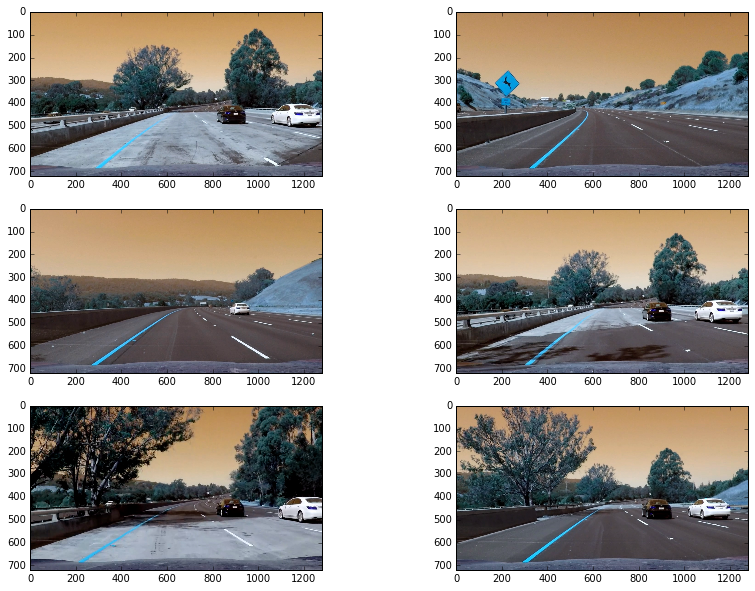

In [33]:
# load test images
img1 = cv2.imread('test_images/test1.jpg')
img2 = cv2.imread('test_images/test2.jpg')
img3 = cv2.imread('test_images/test3.jpg')
img4 = cv2.imread('test_images/test4.jpg')
img5 = cv2.imread('test_images/test5.jpg')
img6 = cv2.imread('test_images/test6.jpg')
plt.figure(figsize=(14,10))
plt.subplot(3,2,1)
plt.imshow(img1)
plt.subplot(3,2,2)
plt.imshow(img2)
plt.subplot(3,2,3)
plt.imshow(img3)
plt.subplot(3,2,4)
plt.imshow(img4)
plt.subplot(3,2,5)
plt.imshow(img5)
plt.subplot(3,2,6)
plt.imshow(img6)

### 3.1 Sliding Window

In [34]:
# define a function to draw boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [35]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list


In [36]:
# define the minimum window size
x_min =[300, 1280]
y_min =[400, 530]
xy_min = (80, 80)

# define the maxium window size
x_max =[300, 1280]
y_max =[400, 700]
xy_max = (160, 160)

# intermedian windows
n = 4 # the number of total window sizes
x = []
y = []
xy =[]
# chose the intermediate sizes by interpolation.
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)
 

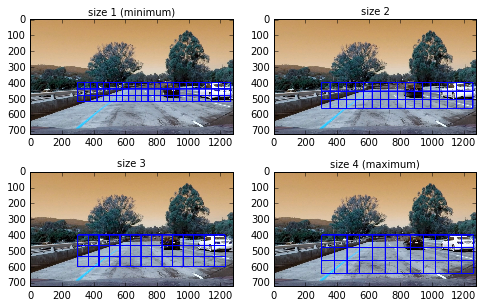

In [37]:
# visualize different window size
windows1 = slide_window(img1, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.5, 0.5))
windows2 = slide_window(img1, x_start_stop= x[1], y_start_stop = y[1], 
                    xy_window= xy[1], xy_overlap=(0.5, 0.5))
windows3 = slide_window(img1, x_start_stop= x[2], y_start_stop = y[2], 
                    xy_window= xy[2], xy_overlap=(0.5, 0.5))
windows4 = slide_window(img1, x_start_stop= x[3], y_start_stop = y[3], 
                    xy_window= xy[3], xy_overlap=(0.5, 0.5))

window_img1 = draw_boxes(img1, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(img1, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(img1, windows3, color=(0, 0, 255), thick=6)
window_img4 = draw_boxes(img1, windows4, color=(0, 0, 255), thick=6)


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,5))
ax1.imshow(window_img1)
ax1.set_title('size 1 (minimum)', fontsize=10)
ax2.imshow(window_img2)
ax2.set_title('size 2', fontsize=10)
ax3.imshow(window_img3)
ax3.set_title('size 3', fontsize=10)
ax4.imshow(window_img4)
ax4.set_title('size 4 (maximum)', fontsize=10)

In [38]:
# combine all windows
windows_all = list(windows1 + windows2 + windows3 + windows4)
print('Total number of windows:',len(windows_all))

Total number of windows: 128


### 3.2 Extract Features From Windows

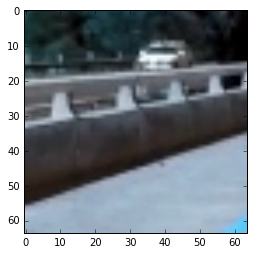

In [39]:
# preprocess the image by crop the window, and resize
def preprocess(img,window):
    # crop the image
    img_crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    # resize the image to 64 by 64
    img_resized = cv2.resize(img_crop, (64, 64))
    return img_resized

# test if the function works
img = preprocess(img1,windows3[1])
plt.imshow(img)

In [40]:
# extract features from a test image
def features_from_img(img):
    # Create a list to append feature vectors to
    features_all = []
    
    for n in range(len(windows_all)):
        # Read in each one by one
        image_rgb = preprocess(img,windows_all[n])
        # extract features
        features = extract_features(image_rgb)
        # append features
        features_all.append(features)       
    # scale
    scaled_features = X_scaler.transform(features_all)
    # Return list of feature vectors
    return scaled_features

In [41]:
# Test the funcion
img_features = features_from_img(img1)
# prediction
pred = clf.predict_proba(img_features)[:,1]
print('The first 10 prediction results', pred[0:10])

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


The first 10 prediction results [ 0.48532995  0.49964141  0.49386078  0.6286049   0.46454518  0.47998052
  0.45503175  0.37200025  0.24273843  0.28781931]


In [42]:
# return windows with car images
def get_car_windows(pred):
    windows_car = []
    for n in range(len(pred)):
        if pred[n] > 0.51: # increase the threshold will miss more True Positive
                           # the classifier have a narrow margin
            windows_car.append(windows_all[n])
    return windows_car

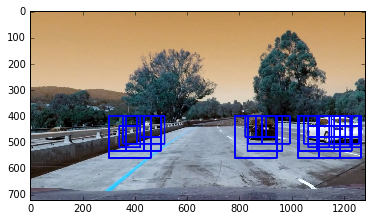

In [43]:
# return the results
windows_car = get_car_windows(pred)

# plot the windows put on the images
img_box = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

In [64]:
# define a function to find boxes with cars
def find_cars(img):
    # extract feature
    img_features = features_from_img(img)
    
    # prediction
    pred = clf.predict_proba(img_features)[:,1]
    
    # get windows with car images
    windows_car = get_car_windows(pred)
    
    return windows_car

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


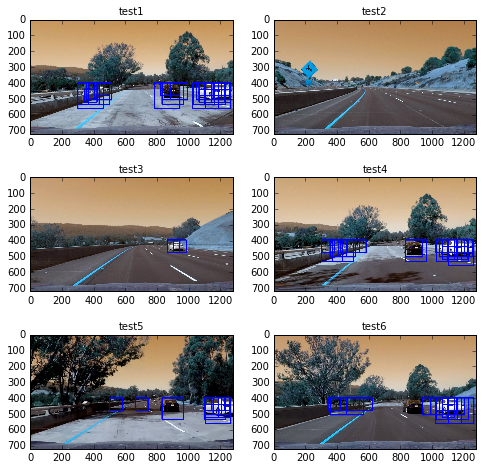

In [65]:
# all test images
windows_car = find_cars(img1)
img_box1 = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img2)
img_box2 = draw_boxes(img2, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img3)
img_box3 = draw_boxes(img3, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img4)
img_box4 = draw_boxes(img4, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img5)
img_box5 = draw_boxes(img5, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img6)
img_box6 = draw_boxes(img6, windows_car, color=(0, 0, 255), thick=6)

f, ((ax1, ax2),(ax3, ax4),(ax5, ax6))= plt.subplots(3, 2, figsize=(8,8))
ax1.imshow(img_box1)
ax1.set_title('test1', fontsize=10)
ax2.imshow(img_box2)
ax2.set_title('test2', fontsize=10)
ax3.imshow(img_box3)
ax3.set_title('test3', fontsize=10)
ax4.imshow(img_box4)
ax4.set_title('test4', fontsize=10)
ax5.imshow(img_box5)
ax5.set_title('test5', fontsize=10)
ax6.imshow(img_box6)
ax6.set_title('test6', fontsize=10)

## 4. Duplicates Removal
Create a heatmap and apply thresholds to removal dupicates (multiple detection of the same car)

### 4.1 Create a Heatmap

In [66]:
# create a heat map
def add_heat(heatmap, boxlist):
    # Iterate through list of bboxes    
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

In [67]:
# truncate value exeed upper limit
def apply_upper_threshold(heatmap, upper):
    # Zero out pixels below the threshold
    heatmap[heatmap > upper] = 1
    # Return thresholded map
    return heatmap

In [68]:
# get value below lower limit to 0
def apply_lower_threshold(heatmap, lower):
    # Zero out pixels below the threshold
    heatmap[heatmap < lower] = 0
    # Return thresholded map
    return heatmap

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3 cars found


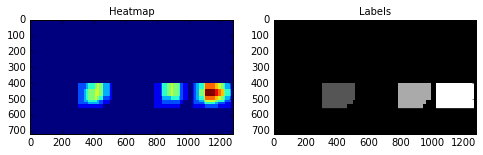

In [69]:
image = img1
bboxes = find_cars(image)

# inicalize heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, bboxes)
labels = label(heatmap)

print(labels[1], 'cars found')

f, (ax1, ax2)= plt.subplots(1, 2, figsize=(8,8))
ax1.imshow(heatmap)
ax1.set_title('Heatmap', fontsize=10)
ax2.imshow(labels[0], cmap='gray')
ax2.set_title('Labels', fontsize=10)

### 4.2 Estimate Bounding Box

In [70]:
# define a function to find bounding box of the labels
def find_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_img = np.copy(img)
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # append the bounding box to a list
        bboxes.append(bbox)
    # Return the bounding boxes
    return bboxes

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


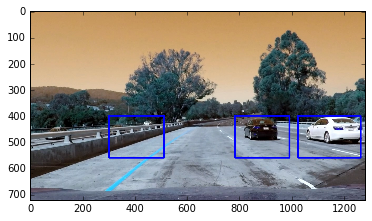

In [71]:
# test the funciton 
image = img1
# find car images
boxes = find_cars(image)
# inicalize a heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# increase heatmap value on car images
heatmap = add_heat(heat, boxes)
# apply threshod
heatmap = apply_lower_threshold(heatmap, 1)
# find labels
labels = label(heatmap)
# find bounding boxes
bboxes = find_labeled_bboxes(image, labels)
# draw bounding boxes
img_box = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

## 5. Vehicle Tracking
Create 'car()' objects and tracking the position and bounding box size

In [72]:
# define a car object
class car():
        def __init__(self):
            self.average_centroid= (0,0) # average centroid
            self.width = 0 # average box width
            self.height = 0 # average height
            self.detected = 0.5  # moving average

### 5.1 Calculate the Distance Between Centroids

In [73]:
# caculate distance
def cal_dist(centroid1, centroid2):
    x1 = centroid1[0]
    y1 = centroid1[1]
    x2 = centroid2[0]
    y2 = centroid2[1]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

# test the function
centroid1 = (1,2)
centroid2 = (2,5)
dist = cal_dist(centroid1, centroid2)
print('Distance:', dist)

Distance: 3.16227766017


### 5.2 Find Nearby Car Object

In [74]:
# define a function to find nearby car object 
def track_car(cntrd,old_Cars):
    threshod_dist = 40 # the maxium distance to consider nearby
    Dist = [] # a list of distance
    if not old_Cars: # if the list of nearby cars is empty
        # return car not found 
        car_found = False 
        car_id = 0
        return car_found,car_id
    else:
        for car in old_Cars:
            # cacualte the distance
            dist = cal_dist(cntrd, car.average_centroid)
            Dist.append(dist)
        car_id = np.argmin(Dist)
        if Dist[car_id] < threshod_dist:
            car_found = True
        else:
            car_found = False
        return car_found, car_id

### 5.3 Find Centroid and the Size of a Bounding Box

In [75]:
# find the centroid and size of a bounding box
def find_box_centroid_size(bboxes):
    box_centroids = []
    box_size = []
    
    for box in bboxes:
        x = int((box[0][0] + box[1][0])/2)
        y = int((box[0][1] + box[1][1])/2)
        box_centroids.append((x,y))

        width =  int((box[1][0] - box[0][0])/2)
        height = int((box[1][1] - box[0][1])/2)
        box_size.append((width,height))
    return box_centroids, box_size

### 5.4 Find Bounding Boxes of Detacted Cars

In [76]:
# define bounding boxes of detacted cars
def find_car_box(Old_Cars, detected_threshold = 0.51):
    box2 = []
    for car2 in Old_Cars:
        if car2.detected > detected_threshold:
            offset = car2.average_centroid          
            width = car2.width
            height = car2.height
            bbox0 = (int(-width+offset[0]),
                     int(-height+offset[1]))
            bbox1 = (int(width+offset[0]),
                     int(height+offset[1]))
            box2.append((bbox0,bbox1))
    return box2

### 5.5 Vechile Tracking

In [77]:
# video pipline
def process_img(image):
    # define car object
    class car():
        def __init__(self):
            self.average_centroid= (0,0) # average centroid
            self.width = 0 # average box width
            self.height = 0 # average height
            self.detected = 0.5  # moving average
    
    global Detected_Cars
    global heatmap
    
    # make a copy of the incial image
    draw_img = np.copy(image)
    
    # find windows that contains cars
    boxes = find_cars(image)
    
    # draw windows that contains cars
    draw_img = draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=2)


    # create a new heat map
    heatmap_new = np.zeros_like(image[:,:,0]).astype(np.float)
    # increase heatmap value on windows contain cars
    heatmap_new = add_heat(heatmap_new, boxes)
    # truncate the value if it's greater than 1. 
    # It's easy to set the threshold value for the 
    # moving average funciton, if the values are bounded
    heatmap_new = apply_upper_threshold(heatmap_new,1)
    
    # update the heatmap with the moving average algorithm 
    # so that, if car image are no longer detacted, that area "cool" down
    heatmap = 0.9*heatmap + 0.1*heatmap_new
        
    
    # wrap heatmap to the orignal image
    wrap_img = np.zeros_like(image) # inicalize
    wrap_img[:,:,1] = heatmap[:]*250 # adding heat map
    # blend image with the heat map
    draw_img = cv2.addWeighted(draw_img, 1, wrap_img, 0.5, 0)

    # create a new heatmap to show the heatmap with more certainty 
    # by thresholding the heatmap value
    heatmap_sure = np.copy(heatmap)
    # get area of higher certainty by thredholding the heatmap
    heatmap_sure = apply_lower_threshold(heatmap_sure, 0.97)
    #labels of areas
    labels = label(heatmap_sure)
    # finding the bounding box of labeled area
    bounding_boxes = find_labeled_bboxes(image, labels)
    
     
    # find centroy and size of bounding box
    centroids,box_size = find_box_centroid_size(bounding_boxes)
    

    New_Cars = [] # inicalize a list of new found cars
    for n in range(len(centroids)):
        # find nearby car object          
        car_found, k = track_car(centroids[n],Detected_Cars) # return a number 
        if car_found  == True:
            # update detected car object
            # update centroid using moving average
            Detected_Cars[k].average_centroid = (int(0.9*Detected_Cars[k].average_centroid[0] + 0.1*centroids[n][0]),
                                    int(0.9*Detected_Cars[k].average_centroid[1] + 0.1*centroids[n][1]))         
            # update bounding box width using moving average
            Detected_Cars[k].width =   math.ceil(0.9*Detected_Cars[k].width + 0.1*box_size[n][0]) # round up
            # update bounding box height using moving average
            Detected_Cars[k].height =  math.ceil(0.9*Detected_Cars[k].height + 0.1*box_size[n][1])
            # update detected value
            Detected_Cars[k].detected = Detected_Cars[k].detected + 0.2

        else: # add new car
            new_car = car()
            # inicalize the car object using the size 
            # and centroid of the bounding box
            new_car.average_centroid = centroids[n]
            new_car.width =  box_size[n][0]
            new_car.height = box_size[n][1]            
            New_Cars.append(new_car)
            
    # combine new_cars to detected cars
    Detected_Cars2 = list(Detected_Cars) # make a copy
    Detected_Cars = New_Cars[:] # add new cars
    if Detected_Cars2: # if is not empty
        for car in Detected_Cars2:
            # if the detected value greater than the threshold add to the list
            # if not discard
            if car.detected > 0.17: 
                # add to the detected cars list
                Detected_Cars.append(car)
            
    # find car object that is consistent
    car_boxes = find_car_box(Detected_Cars, detected_threshold = 0.55) #0.51
    # draw bounding boxes on car object that is more certain
    draw_img = draw_boxes(draw_img, car_boxes, color=(255, 0, 0), thick=5)         
            
    # depreciate old car values, so if it no longer detacted the value fade away
    for car in Detected_Cars:
        car.detected = car.detected*0.8 # depreciate old value
    
    return draw_img

In [78]:
#Functions for the main pipeline are defined here 
def undistort_image(image,mtx,dist):
    undist_image = cv2.undistort(image,mtx,dist,None,mtx)
    return undist_image
def gaussian_blur(image,kernel=5):
    blur_image = cv2.GaussianBlur(image,(kernel,kernel),0)
    return blur_image
def clahe(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(6,6))    
    transform = clahe.apply(v)
    res= cv2.merge((h,s,transform))
    res = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
    return res
def abs_sobel(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output
def mag_thresh(img, sobel_kernel=3, thresh=(20,100)):
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))    
    binary_output = 0*grad_s 
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut
def warp_image(img,src,dst,shape):
    Mat = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, Mat, shape, flags=cv2.INTER_LINEAR)
    Mat_inv = cv2.getPerspectiveTransform(dst, src)
    return warped,Mat,Mat_inv
def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask
def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def get_first(img,window):
    
    # This function gets the initial mask
    
    img = gaussian_blur(img,5)
    shape = np.shape(img)
    mov_filtsize = shape[1]/50.
    hista = np.mean(img[int(shape[0]/2):,:],axis=0)
    hista = moving_average(hista,mov_filtsize)
    
    peaks = find_peaks_cwt(hista,[100], max_distances=[800])

    valid_peaks = np.array([hista[peaks[i]] for i in range(len(peaks)) ])
    peaks_sorted = np.argsort(-valid_peaks)

    R_peak = peaks[peaks_sorted[0]]
    L_peak = peaks[peaks_sorted[1]]
    if R_peak<L_peak:
        temp = R_peak
        R_peak = L_peak
        L_peak = temp

    n_vals = 8
    ind_min_L = L_peak-window
    ind_max_L = L_peak+window

    ind_min_R = R_peak-window
    ind_max_R = R_peak+window

    Left_mask = np.zeros_like(img)
    Right_mask = np.zeros_like(img)

    pre_R_peak = R_peak
    pre_L_peakv = L_peak
    
    # Split image into 8 parts and compute histogram on each part
    
    for i in range(8):
        img_y1 = int(shape[0]-shape[0]*i/8)
        img_y2 = int(shape[0]-shape[0]*(i+1)/8)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        peaks = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(peaks)>1.5:
            valid_peaks = np.array([hista[peaks[i]] for i in range(len(peaks)) ])
            peaks_sorted = np.argsort(-valid_peaks)

            R_peak = peaks[peaks_sorted[0]]
            L_peak = peaks[peaks_sorted[1]]
            if R_peak<L_peak:
                temp = R_peak
                R_peak = L_peak
                L_peak = temp
            
        else:
        # If no pixels are found, use previous ones. 
            if len(peaks)==1:
                if (np.abs(peaks[0]-pre_R_peak)<np.abs(peaks[0]-pre_L_peakv)):
                    R_peak = peaks[0]
                    L_peak = pre_L_peakv
                else:
                    L_peak = peaks[0]
                    R_peak = pre_R_peak
            else:
                L_peak = pre_L_peakv
                R_peak = pre_R_peak
            
            
        # If new center is more than 60pixels away, use previous
        # Outlier rejection
        if np.abs(L_peak-pre_L_peakv)>=60:
            L_peak = pre_L_peakv

        if np.abs(R_peak-pre_R_peak)>=60:
            R_peak = pre_R_peak
            
    
            
        Left_mask[img_y2:img_y1,int(L_peak-window):int(L_peak+window)] = 1.
        Right_mask[img_y2:img_y1,int(R_peak-window):int(R_peak+window)] = 1.
        
        pre_L_peakv = L_peak
        pre_R_peak = R_peak
        
    return Left_mask,Right_mask
def get_mask(image, polynomial_fit,window):
    mask = np.zeros_like(image)
    shape = np.shape(image)
    
    polynomial_points = []
    points = []
    
    for i in range(8):
        image_y1 = int(shape[0]-shape[0]*i/8)
        image_y2 = int(shape[0]-shape[0]*(i+1)/8)
        
        point = (image_y1+image_y2)/2
        points.append(point)
        polynomial_point = np.round(polynomial_fit[0]*point**2 + polynomial_fit[1]*point + polynomial_fit[2])
        polynomial_points.append(polynomial_point)
        
        mask[image_y2:image_y1,int(polynomial_point-window):int(polynomial_point+window)]=1.
        
    return mask,np.array(polynomial_points),np.array(points)

def get_val(y,polynomial):
    return polynomial[0]*y**2 + polynomial[1]*y + polynomial[2]

def draw_pw_lines(image,points,colour):
    points = np.int_(points)
    for i in range(10):
        x1 = points[0][i][0]
        y1 = points[0][i][1]
        x2 = points[0][i+1][0]
        y2 = points[0][i+1][1]
        cv2.line(image,(x1,y1),(x2,y2),colour,40)
        
def draw_mid_lines(image,points1,points2,colour):
    points1 = np.int_(points1)
    points2 = np.int_(points2)
    points_x=[]
    points_y=[]
    for i in range(10):
        x1 = (points1[0][i][0]+points2[0][i][0])//2
        y1 = points1[0][9-i+1][1]
        x2 = (points1[0][i+1][0]+points2[0][i+1][0])//2
        y2 = points1[0][9-i][1]
        cv2.line(image,(x2,y2),(x1,y1),colour,20)
        


def get_curvature(polynomial,points):
    A = polynomial[0]
    B = polynomial[1]
    curvature = ((1+(2*A*points+B)**2)**1.5)/2/A
    return curvature

def stack_arr(array):
    return np.stack((array,array,array),axis=2)

def apply_perspective_transform(image):
    # Applies bird-eye perspective transform to an image
    shape = image.shape
    ht_window = np.uint(shape[0]/1.5)
    hb_window = np.uint(shape[0])
    c_window = np.uint(shape[1]/2)
    ctl_window = c_window - .25*np.uint(shape[1]/2)
    ctr_window = c_window + .25*np.uint(shape[1]/2)
    cbl_window = c_window - 1*np.uint(shape[1]/2)
    cbr_window = c_window + 1*np.uint(shape[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,shape[0]],[shape[1],shape[0]],
                  [shape[1],0],[0,0]])
    
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(shape[1],shape[0])) # returns birds eye image
    return warped,M_warp,Minv_warp

In [79]:
def pipeline(image):
    
    global pre_L_fit   
    global pre_R_fit
    global col_R_prev
    global col_L_prev
    global set_prev
    global Left_mask
    global Right_mask
    

    # Undistort image

    image = undistort_image(image, mtx_camera , dist_camera )
    image = gaussian_blur(image, kernel=5)
    shape = np.shape(image)
    
    # Define window for perspective transform
    warped,M_warp,Minv_warp = apply_perspective_transform(image)
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 20, 80, 50])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  0,   0,   200])
    white_hsv_high = np.array([ 255, 40, 255])
    # get yellow and white masks 
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    # Combine white and yellow masks into 1
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    # Convert image to HLS scheme
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    # Apply sobel filters on L and S channels.
    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel(img_gs,'x',5,(80,225))
    img_abs_y = abs_sobel(img_gs,'y',5,(150,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel(img_gs,'x',5,(80,255))
    img_abs_y = abs_sobel(img_gs,'y',5,(150,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    

    # Combine sobel filter information from L and S channels.
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    image_cmb = gaussian_blur(image_cmb,25)
    

    # Combine masks from sobel and color masks.

    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.6)]=1
    
    
    # If this is first frame, get new mask.
    if set_prev == 0:
        image_cmb1 = gaussian_blur(image_cmb1,5)
        Left_mask,Right_mask = get_first(image_cmb1,40)

        
        
    # Define all colors as white to start.         
    col_R = (255,255,0)
    col_L = (255,255,0)
    
    # Apply mask to sobel images and compute polynomial fit for left. 
    img_L = np.copy(image_cmb1)
    img_L = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = Left_mask)
    vals = np.argwhere(img_L>.5)
    if len(vals)<5: ## If less than 5 points 
        left_fit = pre_L_fit
        col_L = col_L_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        left_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
            col_L = (255,255,0)
            
    # Apply mask to sobel images and compute polynomial fit for right. 

    img_R = np.copy(image_cmb1)
    img_R = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = Right_mask)
    vals = np.argwhere(img_R>.5)
        
    if len(vals)<5:
        right_fit = pre_R_fit
        col_R = col_R_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        right_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
            col_R = (255,255,0)
    
    
    ## assign initial mask, and save coefficient values for next frame
            
    if set_prev == 0:
        set_prev = 1
        pre_R_fit = right_fit
        pre_L_fit  = left_fit
    
       
    ## Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-pre_R_fit[0])**2) #/np.sum(pre_R_fit[0]**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = pre_R_fit
        col_R = col_R_prev
    else:
        right_fit = .4*right_fit+.6*pre_R_fit
        
    ## Check error between current coefficient and on from previous frame
    err_p_L = np.sum((left_fit[0]-pre_L_fit[0])**2) #/np.sum(pre_R_fit[0]**2)
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit = pre_L_fit
        col_L = col_L_prev
    else:
        left_fit =  .4* left_fit+.6* pre_L_fit
    

    ## Compute lane mask for future frame 
    Left_mask,left_pts,img_pts = get_mask(image_cmb1,left_fit,window)
    Right_mask,right_pts,img_pts = get_mask(image_cmb1,right_fit,window)
     
        
    ## Compute lanes
        
    right_y = np.arange(11)*shape[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*shape[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    

    ## Compute intercepts
    left_bot = get_val(shape[0],left_fit)
    right_bot = get_val(shape[0],right_fit)
    
    ## Compute center location
    val_center = (left_bot+right_bot)/2.0
    
    ## Compute lane offset
    dist_offset = val_center - shape[1]/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    if dist_offset>30:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,100, 200))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,100,200))
        
    color_warp_d = color_warp
    #mid_level = np.int_(pts_left-val_center)
    # Draw the lane onto the warped blank image    
    draw_pw_lines(color_warp_d,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp_d,np.int_(pts_right),col_R)
    #draw_mid_lines(color_warp_d,np.int_(pts_left),np.int_(pts_right),(255,0,0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    #newwarp_d = cv2.warpPerspective(color_warp_d, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.75, 0)
    #result = cv2.addWeighted(result, 1, newwarp_d, 0.75, 0)
    
    left_curve = get_curvature(left_fit,shape[0]/2)
    Right_curve = get_curvature(right_fit,shape[0]/2)
    
    str_curv = 'Curvature: Left = ' + str(np.round(left_curve,2)) + ', Right = ' + str(np.round(Right_curve,2))   
    # Change color if distance is more than 30 cm
    font = cv2.FONT_HERSHEY_COMPLEX    
    if dist_offset<30:
        cv2.putText(result, str_curv, (30, 60), font, 1, (0,0,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (0,0,0), 2)
    else:
        cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
    
    
    pre_R_fit = right_fit
    pre_L_fit  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L
    
    
    #return result    # using cv2 for drawing text in diagnostic pipeline.

    
    if screen_out == 1:
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = result
        diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA) 
        diagScreen[0:240, 1600:1920] = cv2.resize(stack_arr(mask_lane), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1280:1600] = cv2.resize(apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[600:1080, 1280:1920] = cv2.resize(color_warp, (640,480), interpolation=cv2.INTER_AREA)*4
        diagScreen[720:840, 0:1280] = middlepanel
        diagScreen[840:1080, 0:320] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*Left_mask), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*Right_mask), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
    
        diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*Left_mask+255*Right_mask), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*cv2.bitwise_and(image_cmb1,image_cmb1,
                                                                              mask=Left_mask+Right_mask)),
                                                (320,240), interpolation=cv2.INTER_AREA)
        return diagScreen
    else:
        return result

In [96]:
def final(image):
    image3 = undistort_image(image, mtx_camera , dist_camera )
    image1 = process_img(image3)
    image2 = pipeline(image)
    result = cv2.addWeighted(image1, 0.5, image2, 0.5, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result   

In [97]:
import math
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import Image as ipimag
from PIL import Image as pimag
import glob

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


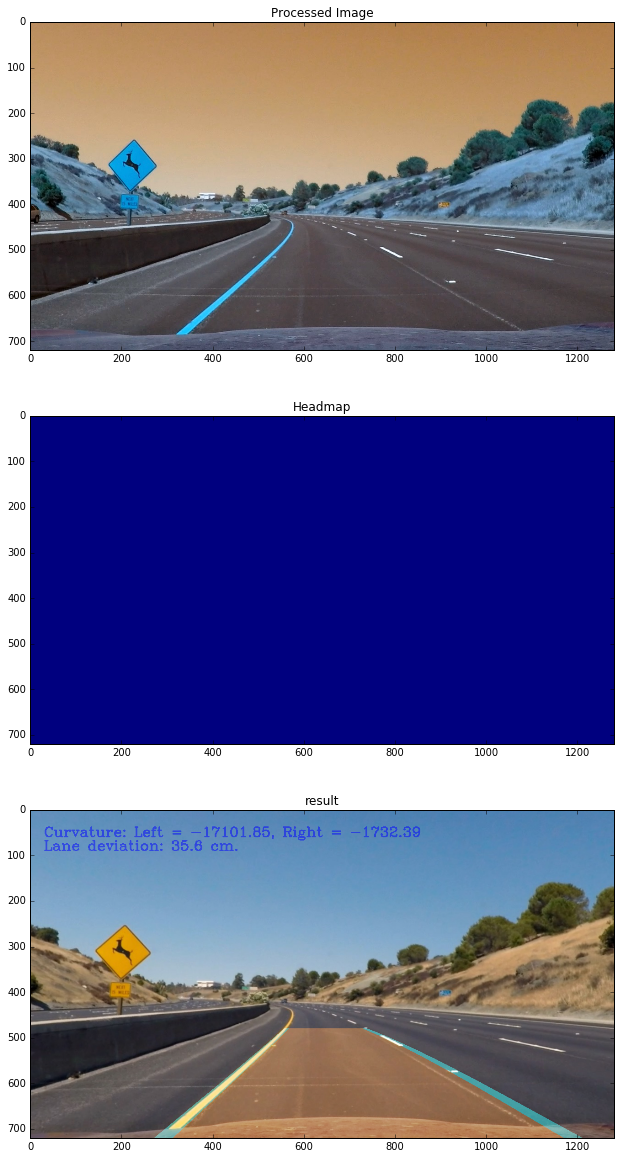

In [101]:
# test on one frame
global Detected_Cars
global heatmap
# inicalize
heatmap = np.zeros_like(img1[:,:,0]).astype(np.float)
Detected_Cars = []
screen_out = 0
set_prev = 0
img1_x =process_img(img2)
res = final(img2)
plt.figure(figsize=(24,20))
plt.subplot(311)
plt.imshow(img1_x)
plt.title('Processed Image')
plt.subplot(312)
plt.imshow(heatmap)
plt.title('Headmap')
plt.subplot(313)
plt.imshow(res)
plt.title('result')

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


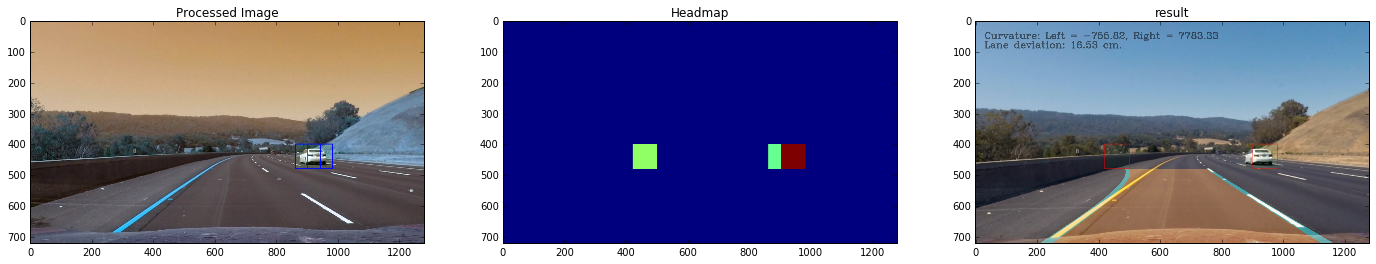

In [106]:
# test on one frame
global Detected_Cars
global heatmap
# inicalize
heatmap = np.zeros_like(img1[:,:,0]).astype(np.float)
Detected_Cars = []
screen_out = 0
set_prev = 0
img1_x =process_img(img3)
res = final(img3)
plt.figure(figsize=(24,20))
plt.subplot(131)
plt.imshow(img1_x)
plt.title('Processed Image')
plt.subplot(132)
plt.imshow(heatmap)
plt.title('Headmap')
plt.subplot(133)
plt.imshow(res)
plt.title('result')

## 6. Video Pipline
Create a pipline to detect cars in a video stream
**Visualization:**
* Detected windows:       Blue boxes
* Heatmap:                Green area
* Bounding boxes of cars: Red boxes

In [105]:
#process on a video
global Detected_Cars
global heatmap 
heatmap = np.zeros_like(img1[:,:,0]).astype(np.float) 
Detected_Cars = []

# output video directory
video_output = 'project_video_after.mp4'
# input video directory
clip1 = VideoFileClip("project_video.mp4")
# video process pipline
video_clip = clip1.fl_image(final) 
# write processed files
%time video_clip.write_videofile(video_output, audio=False)

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



MoviePy: building video file project_video_after.mp4
----------------------------------------

Writing video into project_video_after.mp4


  0%|                                                                                         | 0/1210 [00:00<?, ?it/s]C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [10:24<00:00,  1.99it/s]


Done writing video in project_video_after.mp4 !
Your video is ready !
Wall time: 10min 24s
